In [1]:
import NBHD
import dataset_utils
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd 
import torch
import torch.nn as nn
import torch.optim as optim

from pytorch_metric_learning import distances, losses, miners, reducers

torch.set_printoptions(profile="full")

def get_Cosine_margin(model, x_test, y_test=None):
    def cosine_distance(a, b):
        return 1 - torch.cosine_similarity(a[:, np.newaxis, :], b, dim=-1)
    
    # Compute test samples' Hamming distance
    class_hvs = model.class_hvs.data
    test_enc_hvs = model.encoding(x_test)
    test_Cosine_dist = cosine_distance(test_enc_hvs, class_hvs)

    sorted_test_Cosine_distance, _ = torch.sort(test_Cosine_dist, dim=-1, descending=False)
    test_enc_hvs_Cosine_margin = (sorted_test_Cosine_distance[:,1:]-sorted_test_Cosine_distance[:,0].unsqueeze(dim=1)).mean(dim=1).cuda()
    mean_test_Cosine_margin = torch.mean(test_enc_hvs_Cosine_margin).item()

    return mean_test_Cosine_margin

def get_Hamming_margin(model, x_test, y_test=None):
	def Hamming_distance(a, b):
		D = a.size()[1]
		return (D - a @ b.T)/2

	# # Compute mean Hamming distance between class HVS
	class_hvs = model.quantize_class_hvs(model.class_hvs.data, soft = False)
	# class_Hamming_distance = Hamming_distance(class_hvs, class_hvs)
	# mean_class_Hamming_distance = torch.mean(class_Hamming_distance).item()
	

	# Compute test samples' Hamming distance
	test_enc_hvs = model.encoding(x_test, soft = False)
	test_Hamming_dist = Hamming_distance(test_enc_hvs, class_hvs)

	sorted_test_Hamming_distance, _ = torch.sort(test_Hamming_dist, dim=-1, descending=False)
	test_enc_hvs_Hamming_margin = (sorted_test_Hamming_distance[:,1:]-sorted_test_Hamming_distance[:,0].unsqueeze(dim=1)).mean(dim=1).cuda()
	mean_test_Hamming_margin = torch.mean(test_enc_hvs_Hamming_margin).item()

	return mean_test_Hamming_margin

def HD_test(model, x_test, y_test):
    out = model(x_test, embedding=False)
    preds = torch.argmax(out, dim=-1)

    acc = torch.mean((preds==y_test).float())	
    return acc

def visualize(model, test_loader, nClasses, device="cuda"):
    for batch_idx, (data, labels) in enumerate(test_loader):
        data, labels = data.to(device), labels.to(device)
        out = model(data, embedding=False)
        for label in range(nClasses):
            res = out[labels == label].cpu().detach()
            sns.heatmap(res)
            plt.title("label: {}".format(label))
            plt.show()
        break

def plot_quant(model, x_test, label):
        x = torch.linspace( model.quantize_data.weights[0].item() - 5, model.quantize_data.weights[len(model.quantize_data.weights) - 1].item() + 5 , 1000)
        y1 = model.quantize_data(x, soft = False)
        y2 = model.quantize_data(x, soft = True).detach()
        
        plt.plot(x, y1, c="red", label = "Hard Quantization")
        plt.plot(x, y2, c="blue", label = "Soft Quantization")
        plt.xlabel("X")
        plt.ylabel("Y")
        plt.title("Quantize function over learning operations. Levels: {}, Iteration:{}".format(levels, label))
        plt.legend()
        plt.show()

        sns.displot(model.class_hv_distribution.cpu().flatten().detach())
        for weight in model.quantize_class_hvs.weights.detach():
            plt.axvline(weight, ls="--", c = "red")
        plt.title("non-quantized class_hvs distribution")
        plt.show()
        sns.displot(model.class_hvs.cpu().flatten().detach())
        plt.title("quantized class_hvs distribution")
        plt.show()
        
        

        y3 = model.encoding(x_test, quantize=False).cpu().flatten().detach()
        y4 = model.quantize_data(y3, soft = False).cpu()
        sns.displot(y3)
        plt.title("encoding distribution")
        for weight in model.quantize_data.weights.detach():
            plt.axvline(weight, ls="--", c = "red")
        plt.show()
        sns.displot(y4)
        plt.title("encoding quantization distribution")
        plt.show()
        for name, param in model.named_parameters():
            if("quant" in name):
                print(name, param.data)

def test_quantizer(dataset, D = 1000, levels = 3, m=10, HD_lr = 0.05, quant_lr=1.0, t=0.7, metric_lr = 0.01,  enc_type='RP', similarity_type = "cosine", plot=False, visualize=False):
    nFeatures, nClasses, x_train, y_train, x_test, y_test, train_loader, test_loader\
        = dataset_utils.load_dataset(dataset, 256, "cuda")
    model = NBHD.HDC(dim = nFeatures, D=D, num_classes=nClasses, m=m, levels=levels, enc_type=enc_type, similarity_type= similarity_type)

    model.init_quantize(x_train)
    device = "cuda"

    accuracies = []
    margins = []

    num_metric_epochs = 10
    model.class_hvs = nn.parameter.Parameter(data=model.class_hvs)
    optimizer = optim.Adam(model.parameters(), lr=metric_lr)
    distance = distances.CosineSimilarity()

    reducer = reducers.ThresholdReducer(low=0.0)
    loss_func = losses.TripletMarginLoss(margin=0.2, distance=distance, reducer=reducer)
    mining_func = miners.TripletMarginMiner(
        margin=0.2, distance=distance, type_of_triplets="semihard", )

    ### pytorch-metric-learning stuff ###
    for epoch_i in range(1, num_metric_epochs + 1):
        NBHD.metric_train(model, loss_func, mining_func, device, train_loader, optimizer, epoch_i)
        # accuracies.append(HD_test(model, x_test, y_test).item())
        # margins.append(get_Cosine_margin(model, x_test, y_test))
        # for name, param in model.named_parameters():
        #     if("quant" in name):
        #         print(name, param.data)

    if plot:
        plot_quant(model, x_test, "0")
    if visualize:
        visualize(model, test_loader, nClasses)

    model.init_class(x_train, y_train)
    accuracies.append(HD_test(model, x_test, y_test).item())
    margins.append(get_Cosine_margin(model, x_test, y_test))

    num_HD_epoch = 0

    for epoch_i in range(1, num_HD_epoch+1):
        model.HD_train_step(x_train, y_train, lr=HD_lr)
        accuracies.append(HD_test(model, x_test, y_test).item())
        margins.append(get_Cosine_margin(model, x_test, y_test))

    num_quant_epochs = 0

    optimizer = optim.SGD(model.parameters() , quant_lr)

    def cosineLoss(embeddings, labels, t=t):
        similarities = model.similarity(model.class_hvs, embeddings)
        a = (1 - similarities[torch.arange(similarities.size(0)), labels]).abs().mean() #

        similarities[torch.arange(similarities.size(0)), labels] = 0
        b = similarities.abs().mean() #
        return t * a + (1-t) * b

    quant_loss = cosineLoss
    for epoch_i in range(1, num_quant_epochs + 1):
        NBHD.quant_train(model, quant_loss, device, train_loader, optimizer, epoch_i)
        accuracies.append(HD_test(model, x_test, y_test).item())
        margins.append(get_Cosine_margin(model, x_test, y_test))





    num_mixed_epoch = 10
    for epoch_i in range(1, num_mixed_epoch + 1):
        model.HD_train_step(x_train, y_train, lr=HD_lr)
        NBHD.quant_train(model, quant_loss, device, train_loader, optimizer, epoch_i)
        accuracies.append(HD_test(model, x_test, y_test).item())
        margins.append(get_Cosine_margin(model, x_test, y_test))

    
    plt.plot(accuracies, label="Accuracy", c = "blue")
    plt.plot(margins, label="Margins", c="cyan")
    plt.xlabel("iterations")
    plt.ylabel("accuracy")
    # plt.axvline(x=10, c= "red" , ls="--")
    plt.title("Accuracy of {} Levels, {} Dimensions, Dataset:{}".format(levels, D, dataset))
    plt.legend()
    plt.show()
    print("Maximum Accuracy:{}".format(max(accuracies)))
    
    # print("class hv equality: ", torch.equal(before, model.class_hvs) )

    if plot:
            plot_quant(model, x_test, "end")
    if visualize:
        visualize(model, test_loader, nClasses)
    print('Level:',level," Metric_lr:",metric_lr, " Accuracies:" ,accuracies, "Margins:", margins, "t:" , t)
    return accuracies, margins

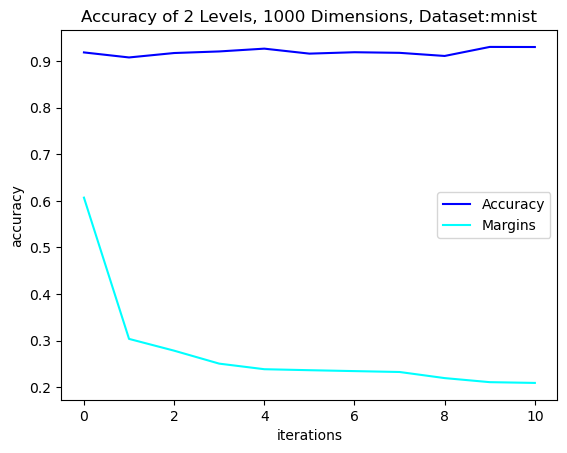

Maximum Accuracy:0.9302999973297119
Level: 2  Metric_lr: 0.001  Accuracies: [0.9185000061988831, 0.9077000021934509, 0.917199969291687, 0.9205999970436096, 0.9265999794006348, 0.9158999919891357, 0.9188999533653259, 0.9175999760627747, 0.9108999967575073, 0.9302999973297119, 0.9300999641418457] Margins: [0.6067662835121155, 0.30353930592536926, 0.27825430035591125, 0.2504350543022156, 0.2384612262248993, 0.23634082078933716, 0.2343907654285431, 0.23249542713165283, 0.21937741339206696, 0.21066522598266602, 0.2090301215648651] t: 0.9


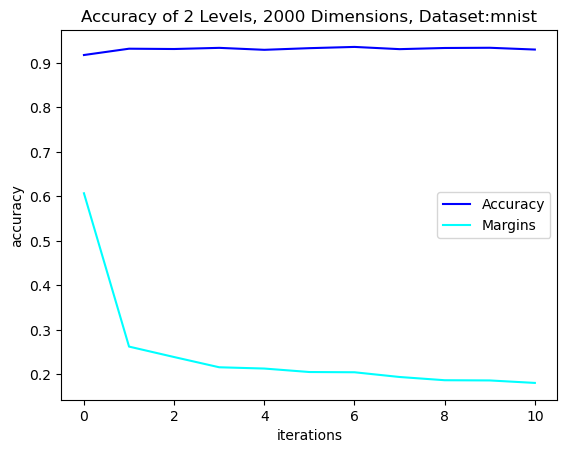

Maximum Accuracy:0.9359999895095825
Level: 2  Metric_lr: 0.001  Accuracies: [0.9177999496459961, 0.9319999814033508, 0.9312999844551086, 0.933899998664856, 0.9294999837875366, 0.9332000017166138, 0.9359999895095825, 0.9309999942779541, 0.9335999488830566, 0.9340999722480774, 0.9300999641418457] Margins: [0.6070888042449951, 0.2624589800834656, 0.23897714912891388, 0.2159777283668518, 0.21311283111572266, 0.2053072154521942, 0.20475532114505768, 0.19413623213768005, 0.1868661642074585, 0.18637707829475403, 0.1808069348335266] t: 0.9


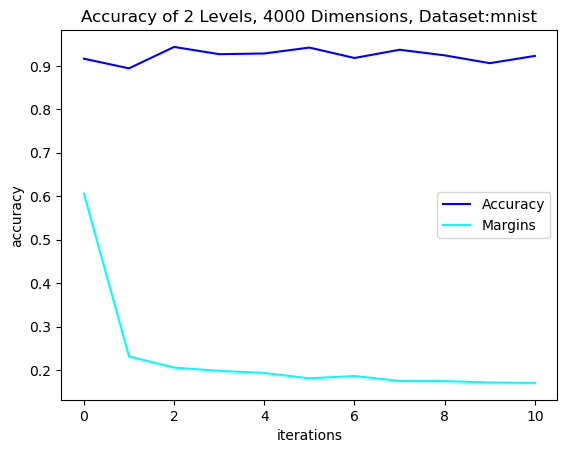

Maximum Accuracy:0.9436999559402466
Level: 2  Metric_lr: 0.001  Accuracies: [0.9165999889373779, 0.8944000005722046, 0.9436999559402466, 0.9269999861717224, 0.9285999536514282, 0.9422000050544739, 0.9181999564170837, 0.9371999502182007, 0.924299955368042, 0.9062999486923218, 0.9229999780654907] Margins: [0.6058698892593384, 0.23138049244880676, 0.20553597807884216, 0.19794750213623047, 0.19310978055000305, 0.18077236413955688, 0.186135932803154, 0.17476195096969604, 0.17432312667369843, 0.1710844486951828, 0.17016805708408356] t: 0.9


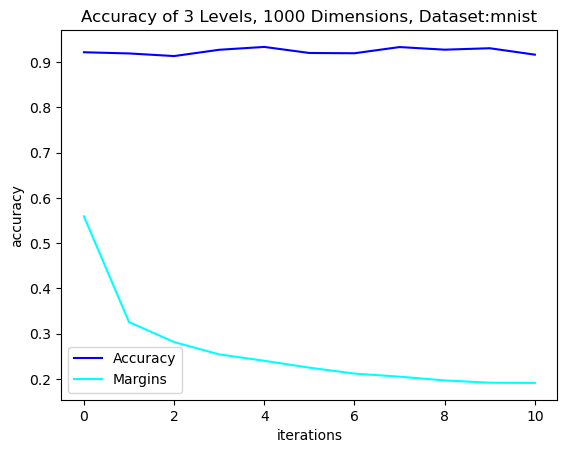

Maximum Accuracy:0.9337999820709229
Level: 3  Metric_lr: 0.001  Accuracies: [0.921999990940094, 0.9193999767303467, 0.913599967956543, 0.9274999499320984, 0.9337999820709229, 0.9203999638557434, 0.9197999835014343, 0.9334999918937683, 0.9276999831199646, 0.930899977684021, 0.916700005531311] Margins: [0.5594043731689453, 0.32575249671936035, 0.2815258502960205, 0.2542959451675415, 0.24015295505523682, 0.2249705046415329, 0.211869016289711, 0.20507121086120605, 0.19676175713539124, 0.19168955087661743, 0.19123874604701996] t: 0.9


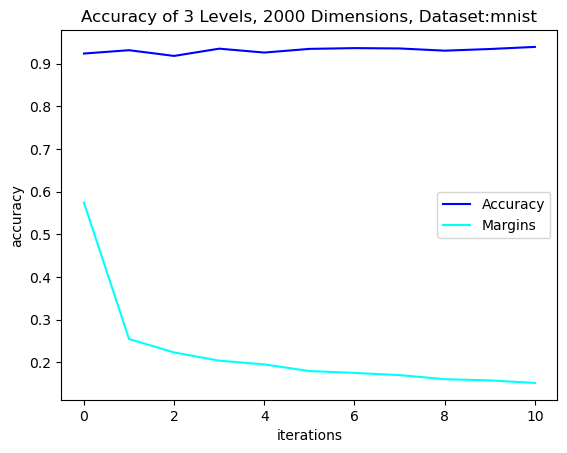

Maximum Accuracy:0.9393999576568604
Level: 3  Metric_lr: 0.001  Accuracies: [0.9238999485969543, 0.9316999912261963, 0.9182999730110168, 0.9352999925613403, 0.9261999726295471, 0.9347999691963196, 0.9365999698638916, 0.9357999563217163, 0.9305999875068665, 0.934499979019165, 0.9393999576568604] Margins: [0.5743457078933716, 0.25431379675865173, 0.22293749451637268, 0.2035728245973587, 0.19483929872512817, 0.17929671704769135, 0.17486895620822906, 0.16975001990795135, 0.16011865437030792, 0.15732420980930328, 0.1513896882534027] t: 0.9


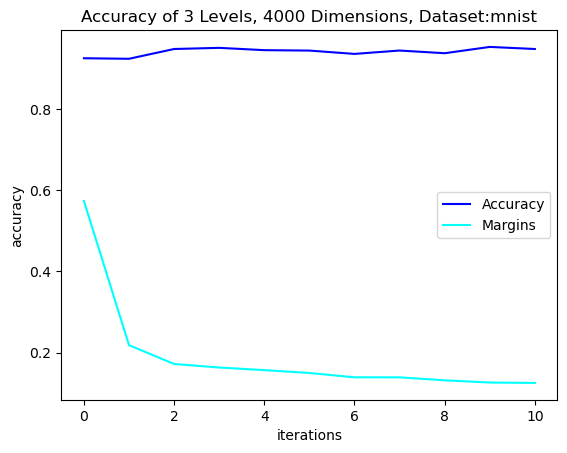

Maximum Accuracy:0.9524999856948853
Level: 3  Metric_lr: 0.001  Accuracies: [0.9246000051498413, 0.9232999682426453, 0.9473999738693237, 0.9501999616622925, 0.9444999694824219, 0.9434999823570251, 0.9352999925613403, 0.9435999989509583, 0.9369999766349792, 0.9524999856948853, 0.9473999738693237] Margins: [0.5727404356002808, 0.21802645921707153, 0.1718350499868393, 0.16311518847942352, 0.1566944122314453, 0.14963944256305695, 0.13899743556976318, 0.13893334567546844, 0.13161730766296387, 0.1261364370584488, 0.12518537044525146] t: 0.9


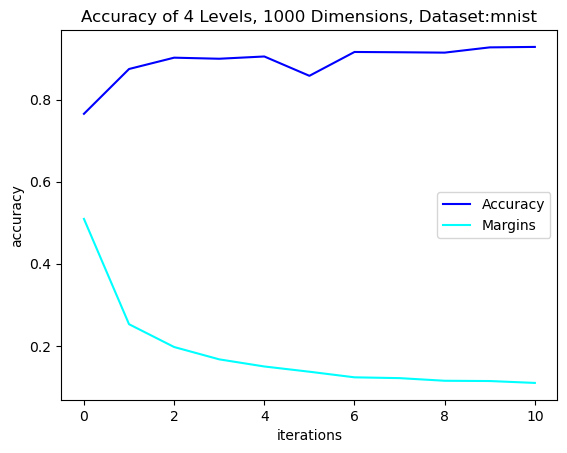

Maximum Accuracy:0.9282999634742737
Level: 4  Metric_lr: 0.001  Accuracies: [0.7652999758720398, 0.8744999766349792, 0.9020999670028687, 0.8994999527931213, 0.9049999713897705, 0.8578999638557434, 0.9159999489784241, 0.9152999520301819, 0.9143999814987183, 0.9271999597549438, 0.9282999634742737] Margins: [0.5092126131057739, 0.252607524394989, 0.19705788791179657, 0.16699299216270447, 0.14962230622768402, 0.1368592083454132, 0.1231808066368103, 0.1212306097149849, 0.11480799317359924, 0.11416108161211014, 0.10955552756786346] t: 0.9


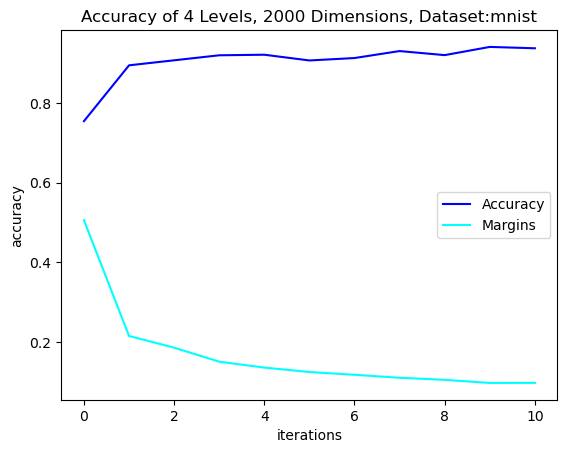

Maximum Accuracy:0.941100001335144
Level: 4  Metric_lr: 0.001  Accuracies: [0.7547000050544739, 0.8948999643325806, 0.9074999690055847, 0.9200999736785889, 0.9214999675750732, 0.9070999622344971, 0.9131999611854553, 0.9307000041007996, 0.9204999804496765, 0.941100001335144, 0.9376999735832214] Margins: [0.5059572458267212, 0.21523788571357727, 0.18592314422130585, 0.15069155395030975, 0.13588155806064606, 0.12470634281635284, 0.11778862029314041, 0.11028695106506348, 0.10511749237775803, 0.0973588302731514, 0.09747787564992905] t: 0.9


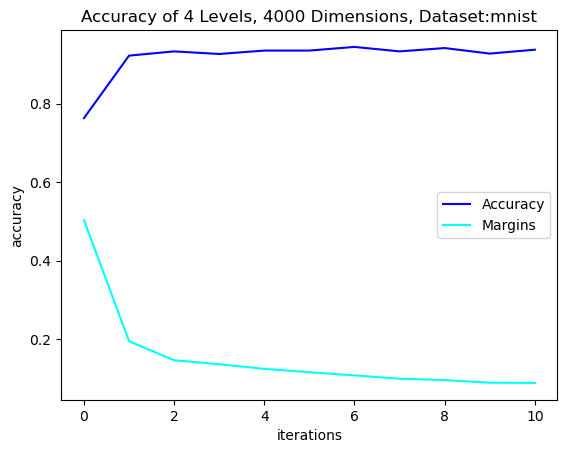

Maximum Accuracy:0.9447999596595764
Level: 4  Metric_lr: 0.001  Accuracies: [0.7630999684333801, 0.9225999712944031, 0.9333999752998352, 0.9267999529838562, 0.9354999661445618, 0.9354999661445618, 0.9447999596595764, 0.9333999752998352, 0.9418999552726746, 0.9277999997138977, 0.9376999735832214] Margins: [0.5030987858772278, 0.19416840374469757, 0.1455669403076172, 0.1353841871023178, 0.12363363802433014, 0.11499951779842377, 0.10691006481647491, 0.0985291451215744, 0.09498082846403122, 0.08828599750995636, 0.08773133158683777] t: 0.9


In [2]:
datasets = ["mnist"]
levels = [2,3,4]
metric_lrs = [0.001]
HD_lrs =[1]
stats = {}
dimensions = [1000,2000, 4000]
quant_lrs = [1.0]
ts = [0.9]

plot = False
vis = False

for dataset in datasets:
    for level in levels:
        for HD_lr in HD_lrs:
            for metric_lr in metric_lrs:
                for quant_lr in quant_lrs:
                    for dimension in dimensions:
                        for t in ts:
                            acc, marg = test_quantizer(dataset=dataset,levels = level, D = dimension, quant_lr =quant_lr, t=t,
                            metric_lr = metric_lr ,HD_lr=HD_lr, enc_type="RP", similarity_type = "cosine", plot=plot, visualize=vis)
                            i = np.argmax(acc)
                            stats[(level, dimension)] = acc[i], marg[i]

In [3]:
import csv

with open('test_Full_10_Metric_10_Mix_mnist.csv', 'w') as output:
    writer = csv.writer(output)
    for key, value in stats.items():
        writer.writerow([key, value])
    
    # for key, value in margs.items():
    #     writer.writerow([key, value])